WE will run some algorithms to see the weak points of some teams and what they can improve to get better next season.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
 


data_dir = r'C:\SportsProject\premier_team_analysis\data'

player_stats_df = pd.read_csv(f'{data_dir}/player_stats.csv')
player_salaries_df = pd.read_csv(f'{data_dir}/player_salaries.csv')
team_stats_df = pd.read_csv(f'{data_dir}/team_stats.csv')
standings_df = pd.read_csv(f'{data_dir}/standings.csv')
fixtures_df = pd.read_csv(f'{data_dir}/fixtures.csv')
team_salary_df = pd.read_csv(f'{data_dir}/team_salary.csv')
player_possession_stats_df = pd.read_csv(f'{data_dir}/player_possession_stats.csv')
team_possession_stats_df = pd.read_csv(f'{data_dir}/team_possession_stats.csv')


#Code from https://www.kaggle.com/code/astonvaz/stats-don-t-lie-premier-league-24-25-deep-dive

df_dict = {
    'team_possession_stats': team_possession_stats_df,
    'player_possession_stats': player_possession_stats_df,
    'team_salary': team_salary_df,
    'standings': standings_df,
    'team_stats': team_stats_df,
    'player_salaries': player_salaries_df,
    'fixtures': fixtures_df,
    'player_stats': player_stats_df
}

def print_df_shape(name, dataframe):
    """Displays dataframe name and shape"""
    print(f"{name} Dataset shape: {dataframe.shape}\n")
    
def display_column_names(name, dataframe):
    """Displays column names in a dataframe"""
    print(f"{name} columns:\n{dataframe.columns.tolist()} \n")
    
def display_first_five_rows(table_name, dataframe):
    print(f"{table_name} data:")
    print(f"{dataframe.head(5)}\n\n")
    
def display_data_types(name, dataframe):
    print(f"{name} data types:")
    print(f"{dataframe.info()}\n")
    

Columns in team_master: ['rank', 'team', 'win', 'loss', 'draw', 'goals_x', 'conceded', 'points', 'last5', 'top_scorer', 'keeper', 'players_x', 'age', 'possession_x', 'goals_y', 'assists', 'penalty_kicks', 'penalty_kick_attempts', 'yellows', 'reds', 'expected_goals', 'expected_assists', 'progressive_carries', 'progressive_passes', 'possession_y', 'touches', 'deffensive_touches', 'middle_touches', 'attacking_touches', 'attempted_take_ons', 'successful_take_ons', 'carries', 'total_distance_carried', 'players_y', 'weekly', 'annual', 'age_mean', 'goals_sum', 'expected_goals_sum', 'progressive_passes_sum', 'Annual_sum', 'Annual_mean']


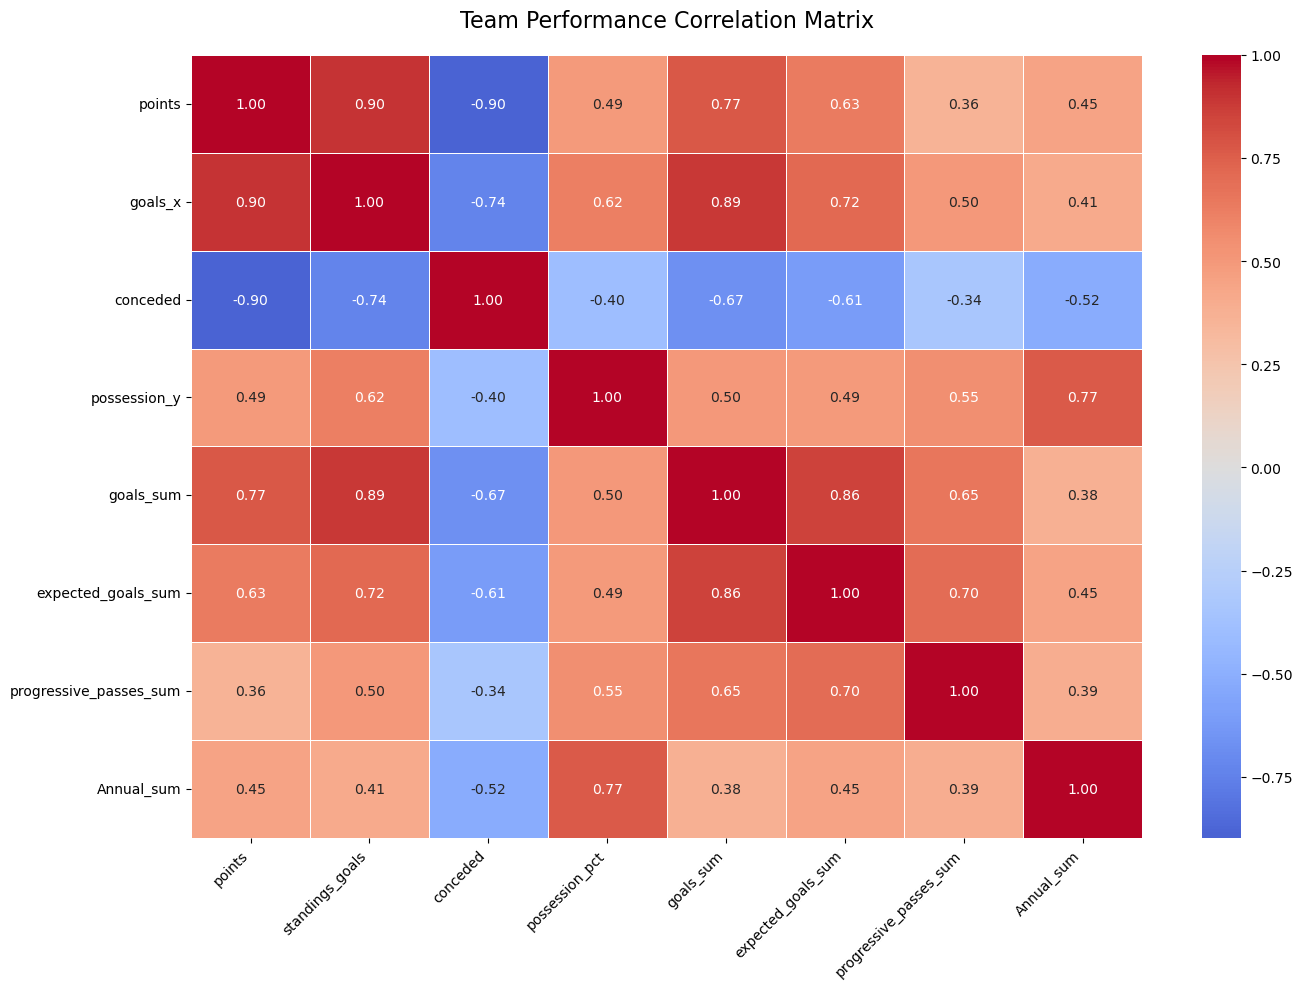

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Correlation analysis between standings and performance metrics
player_stats = df_dict['player_stats']
player_possession = df_dict['player_possession_stats']
player_salaries = df_dict['player_salaries']
team_standings = df_dict['standings']


# Merge on player name (normalize columns)
player_stats = player_stats.rename(columns={'name': 'player'})
player_salaries = player_salaries.rename(columns={'Player': 'player'})

# Merge all data
player_df = player_stats.merge(player_possession, on=['player', 'team', 'age'], suffixes=('', '_pos'), how='inner')
player_df = player_df.merge(player_salaries[['player', 'Annual']], on='player', how='left')

# Create master team dataset by merging all team-related data
team_master = (
    df_dict['standings']
    .merge(df_dict['team_stats'], on='team', how='left')
    .merge(df_dict['team_possession_stats'], on='team', how='left')
    .merge(df_dict['team_salary'], on='team', how='left')
)

team_players = player_df.groupby('team').agg({
    'age': 'mean',
    'goals': 'sum',
    'expected_goals': 'sum',
    'progressive_passes': 'sum',
    'Annual': ['sum', 'mean']
}).reset_index()


# Flatten multi-index columns
team_players.columns = ['_'.join(col).strip('_') for col in team_players.columns.values]

team_master = team_master.merge(team_players, on='team', how='left')

print("Columns in team_master:", team_master.columns.tolist())

# Now run the correlation analysis on the merged data
# Select the correct column versions for correlation
plt.figure(figsize=(14,10))
team_corr = team_master[[
    'points',               # From standings
    'goals_x',              # Goals from standings
    'conceded',             # From standings
    'possession_y',         # From team_possession_stats
    'goals_sum',            # From aggregated players
    'expected_goals_sum',   # From aggregated players
    'progressive_passes_sum', # From aggregated players
    'Annual_sum'            # Total salary spend
]].corr()

# Rename columns for clearer visualization
team_corr = team_corr.rename(columns={
    'goals_x': 'standings_goals',
    'possession_y': 'possession_pct'
})

sns.heatmap(team_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            annot_kws={"size": 10}, linewidths=.5)
plt.title('Team Performance Correlation Matrix', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\bield\AppData\Local\Temp\ipykernel_39008\4294935229.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_df.groupby(['team', 'age_group'])


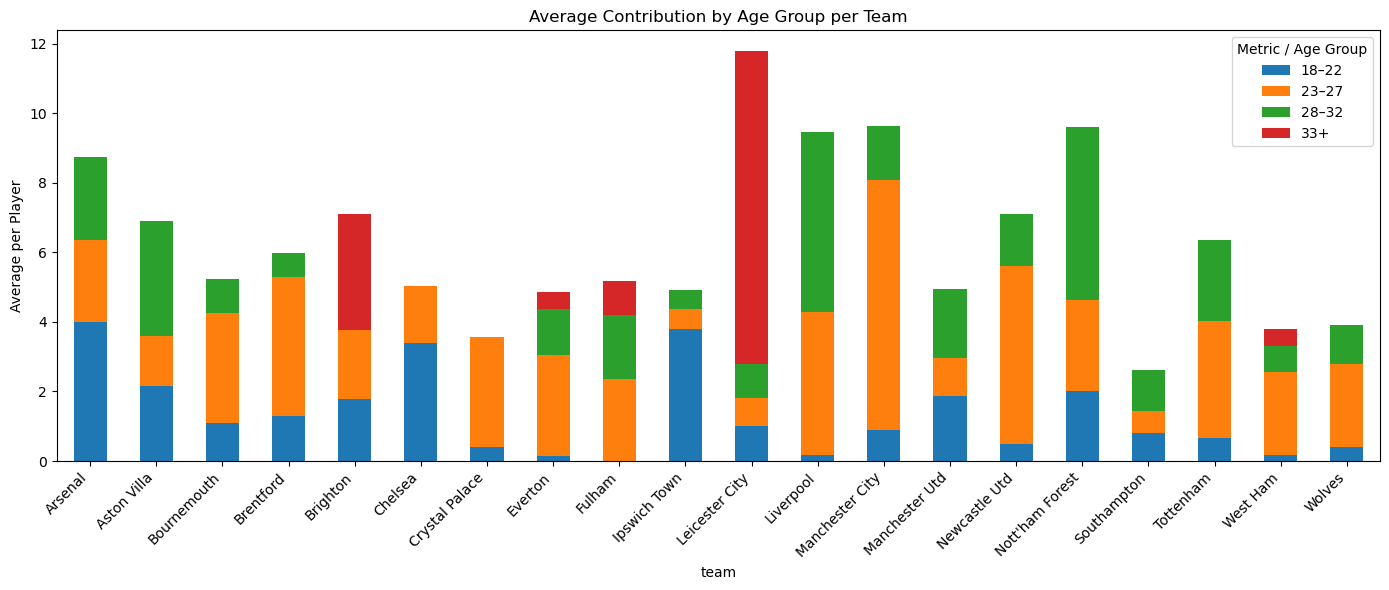

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

age_bins = [18, 23, 28, 33, 40]
age_labels = ['18–22', '23–27', '28–32', '33+']
player_df['age_group'] = pd.cut(player_df['age'], bins=age_bins, labels=age_labels)

age_analysis = (
    player_df.groupby(['team', 'age_group'])
    ['goals']
    .mean()
    .round(2)
)

age_analysis.unstack().plot(kind='bar', figsize=(14,6), stacked=True)
plt.title("Average Contribution by Age Group per Team")
plt.ylabel("Average per Player")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Metric / Age Group')
plt.show()


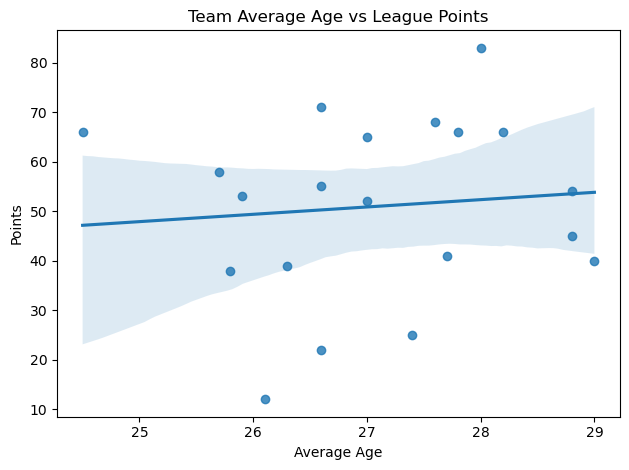

In [17]:
sns.regplot(data=team_master, x='age', y='points')
plt.title('Team Average Age vs League Points')
plt.xlabel('Average Age')
plt.ylabel('Points')
plt.tight_layout()
plt.show()



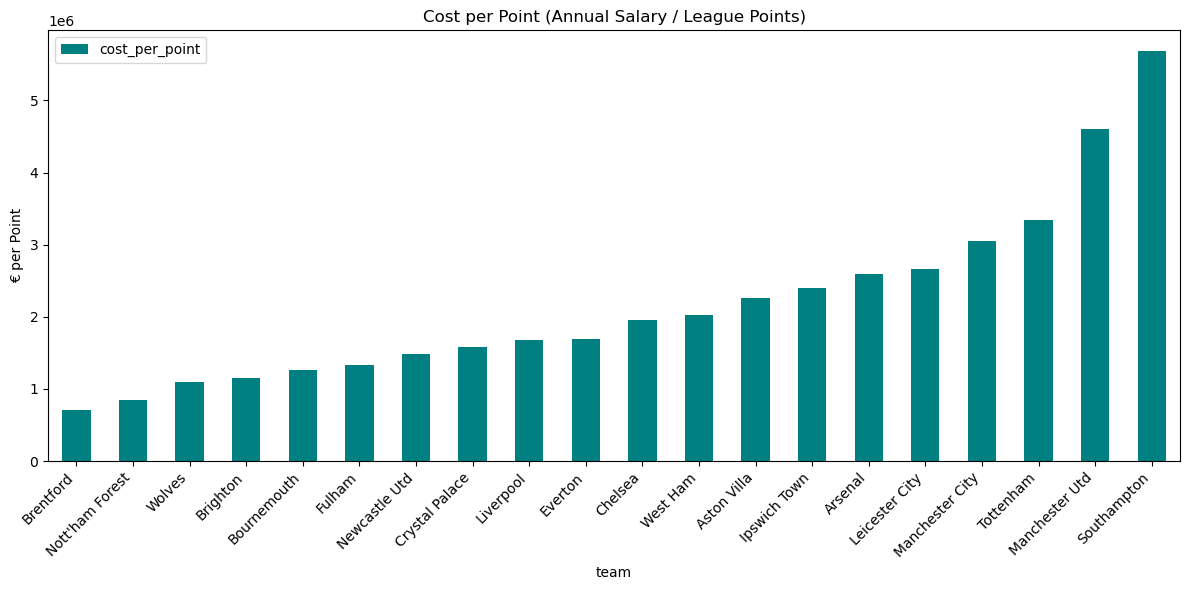

In [19]:
team_master['cost_per_point'] = team_master['Annual_sum'] / team_master['points']

team_master.sort_values('cost_per_point', ascending=True)[['team', 'cost_per_point']].plot(
    x='team', y='cost_per_point', kind='bar', figsize=(12,6), color='teal'
)
plt.title('Cost per Point (Annual Salary / League Points)')
plt.ylabel('€ per Point')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


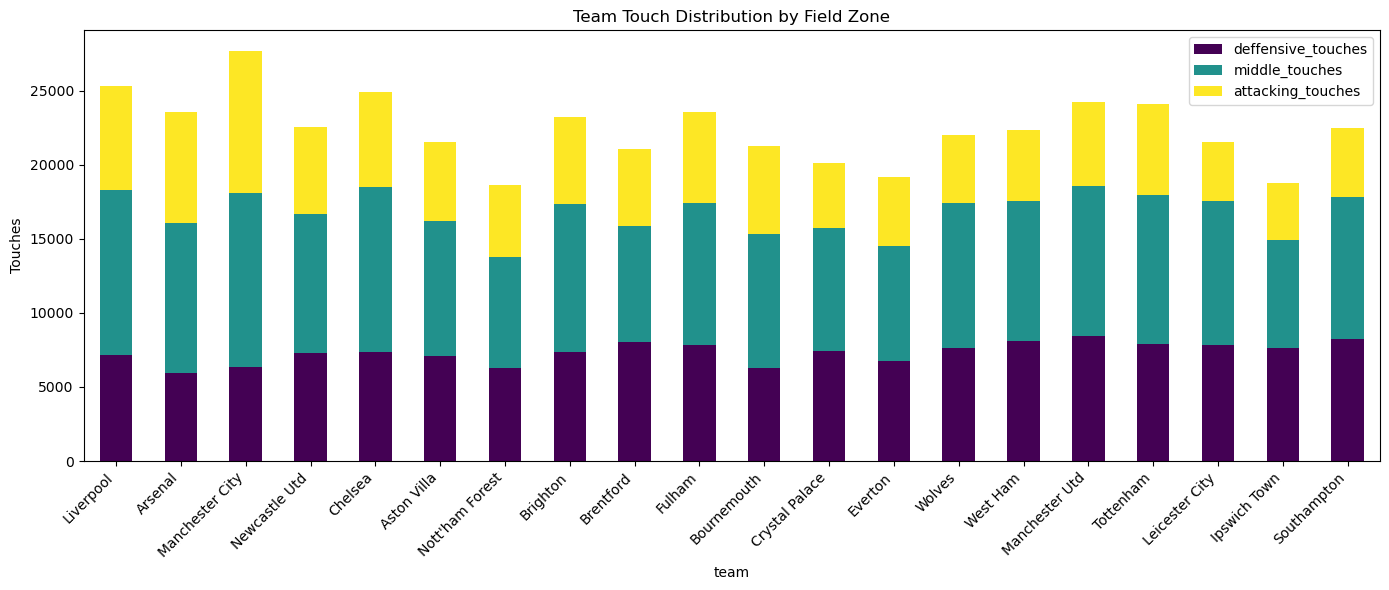

In [20]:
zone_df = team_master[['team', 'deffensive_touches', 'middle_touches', 'attacking_touches']]
zone_df.set_index('team').plot(kind='bar', stacked=True, figsize=(14,6), colormap='viridis')
plt.title('Team Touch Distribution by Field Zone')
plt.ylabel('Touches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


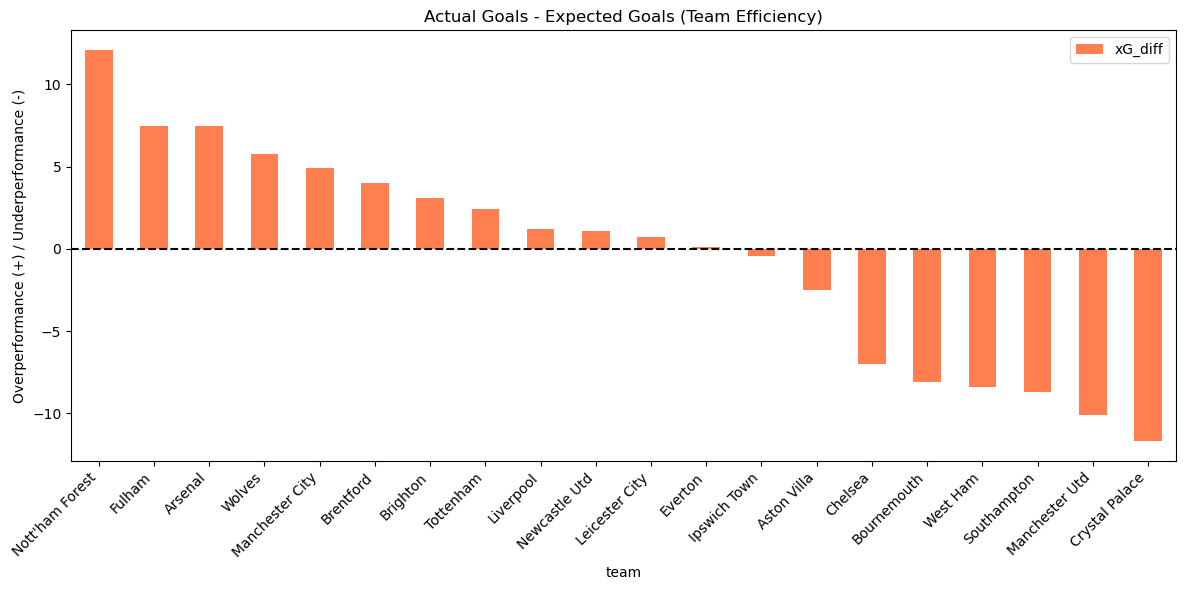

In [21]:
team_master['xG_diff'] = team_master['goals_sum'] - team_master['expected_goals_sum']

team_master.sort_values('xG_diff', ascending=False).plot(
    x='team', y='xG_diff', kind='bar', figsize=(12,6), color='coral'
)
plt.title('Actual Goals - Expected Goals (Team Efficiency)')
plt.ylabel('Overperformance (+) / Underperformance (-)')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


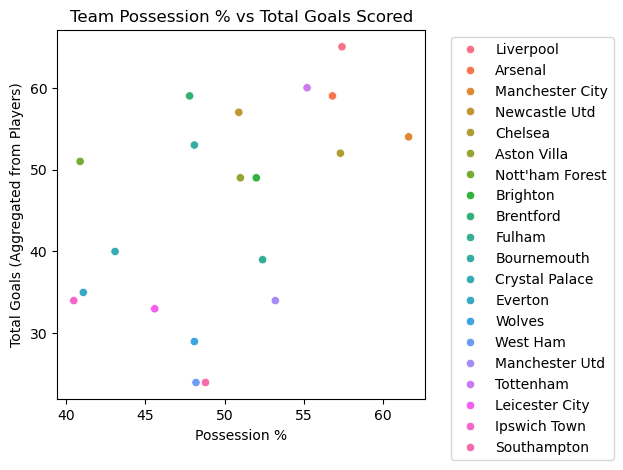

In [22]:
sns.scatterplot(data=team_master, x='possession_y', y='goals_sum', hue='team')
plt.title('Team Possession % vs Total Goals Scored')
plt.xlabel('Possession %')
plt.ylabel('Total Goals (Aggregated from Players)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
